In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn # neural networks
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor


In [12]:
# preprocessing data
df = pd.read_csv("../Dataset/Amazon Sale Report.csv")
df.info()
df.head(10)

C:\Users\T ADITYA\AppData\Local\Temp\ipykernel_13948\1123557912.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Dataset/Amazon Sale Report.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN
5,5,404-1490984-4578765,04-30-22,Shipped,Amazon,Amazon.in,Expedited,SET264,SET264-KR-NP-XL,Set,...,INR,824.00,GHAZIABAD,UTTAR PRADESH,201102.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN,NaN
6,6,408-5748499-6859555,04-30-22,Shipped,Amazon,Amazon.in,Expedited,J0095,J0095-SET-L,Set,...,INR,653.00,CHANDIGARH,CHANDIGARH,160036.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN,NaN
7,7,406-7807733-3785945,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3405,JNE3405-KR-S,kurta,...,INR,399.00,HYDERABAD,TELANGANA,500032.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
8,8,407-5443024-5233168,04-30-22,Cancelled,Amazon,Amazon.in,Expedited,SET200,SET200-KR-NP-A-XXXL,Set,...,NaN,NaN,HYDERABAD,TELANGANA,500008.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN,NaN
9,9,402-4393761-0311520,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3461,JNE3461-KR-XXL,kurta,...,INR,363.00,Chennai,TAMIL NADU,600041.0,IN,NaN,False,NaN,NaN


In [13]:
# Load and preprocess data
df = pd.read_csv("../Dataset/Amazon Sale Report.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y')

# Filter and aggregate data
df = df[['Date', 'Status', 'Qty', 'Amount']]
df = df[df['Status'].str.contains('Shipped')]
df = df.groupby('Date').agg({'Qty': 'sum', 'Amount': 'sum'}).reset_index()

# Remove outliers in Qty
df = df[df['Qty'] > df['Qty'].quantile(0.05)]

# Feature engineering for consistency
df['day_of_week'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['quarter'] = df['Date'].dt.quarter

# Set Date as index and handle missing dates
df = df.set_index('Date').asfreq('D').fillna(method='ffill')

# Scaling Amount for LSTM (as with SARIMAX/XGBoost)
sc_amt = MinMaxScaler()
df['Amount'] = sc_amt.fit_transform(df['Amount'].values.reshape(-1, 1))

# Splitting into train/test sets (80-20 split)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Convert train/test to tensors for LSTM
train_scaled = torch.tensor(train['Amount'].values, dtype=torch.float32).reshape(-1, 1)
test_scaled = torch.tensor(test['Amount'].values, dtype=torch.float32).reshape(-1, 1)

C:\Users\T ADITYA\AppData\Local\Temp\ipykernel_13948\3481342492.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Dataset/Amazon Sale Report.csv")
C:\Users\T ADITYA\AppData\Local\Temp\ipykernel_13948\3481342492.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.set_index('Date').asfreq('D').fillna(method='ffill')


In [14]:
# Splitting Data
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Scaling Data for LSTM
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Amount']])
test_scaled = scaler.transform(test[['Amount']])

# Display dataset size
print(f"Training Data: {len(train)} rows, Testing Data: {len(test)} rows")

Training Data: 70 rows, Testing Data: 18 rows


In [15]:
# Train SARIMA Model
sarima_model = SARIMAX(train['Amount'], order=(3,1,2), seasonal_order=(2,1,2,12))
sarima_fit = sarima_model.fit()

# Forecast
sarima_preds = sarima_fit.forecast(steps=len(test))


c:\Users\T ADITYA\scoop\apps\python310\3.10.11\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\T ADITYA\scoop\apps\python310\3.10.11\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\T ADITYA\scoop\apps\python310\3.10.11\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\T ADITYA\scoop\apps\python310\3.10.11\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed 

In [16]:
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05)
xgb_model.fit(train.drop(columns=['Amount']), train['Amount'])

# Predict
xgb_preds = xgb_model.predict(test.drop(columns=['Amount']))

In [17]:
# load and preprocess data
df = pd.read_csv("../Dataset/Amazon Sale Report.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y')
df = df[['Date','Status','Qty','Amount']]
df = df[df['Status'].str.contains('Shipped')]
df = df.groupby('Date').agg({'Qty':'sum','Amount':'sum'}).reset_index()
df = df[df['Qty'] > df['Qty'].quantile(0.05)]
# Normalise Qty and Amount
sc_qty = MinMaxScaler()
sc_amt = MinMaxScaler()
df['Qty']=sc_qty.fit_transform(df['Qty'].values.reshape(-1,1))
df['Amount'] = sc_amt.fit_transform(df['Amount'].values.reshape(-1,1))

# creating datasets
class tsDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, index):
        return (self.data[index:index+self.seq_len], self.data[index+self.seq_len])

seq_len = 30
qty_values = torch.tensor(df['Qty'].values,dtype=torch.float32)

amount_values = torch.tensor(df['Amount'].values, dtype=torch.float32)
dataset = tsDataset(amount_values, seq_len)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


C:\Users\T ADITYA\AppData\Local\Temp\ipykernel_13948\3029676639.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Dataset/Amazon Sale Report.csv")


In [18]:
# Combined LSTM and Tranformer model
class LSTMTransformer(nn.Module):
    def __init__(self, input_dim=1, lstm_hidden_dim=64, lstm_layers=8, d_model=64, nhead=4, num_transformer_layers=8,dropout=0.3):
        super(LSTMTransformer, self).__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden_dim, lstm_layers, batch_first=True,dropout=dropout)
        self.embedding = nn.Linear(lstm_hidden_dim, d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_transformer_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        transformer_input = self.embedding(lstm_out)
        transformer_input = transformer_input.permute(1, 0, 2)  # (seq_len, batch, feature)
        transformer_out = self.transformer(transformer_input, transformer_input)
        out = self.fc(transformer_out[-1])
        return out
# Instantiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_transformer_model = LSTMTransformer().to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_transformer_model.parameters(), lr=0.0258)

c:\Users\T ADITYA\scoop\apps\python310\3.10.11\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [19]:
def train_model(model, dataloader, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for seq, target in dataloader:
            seq, target = seq.unsqueeze(-1).to(device), target.unsqueeze(-1).to(device)
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}')
        
# Train the combined model
print("Training LSTM-Transformer...")
train_model(lstm_transformer_model, dataloader, optimizer)


Training LSTM-Transformer...
Epoch 1/50, Loss: 6.5116
Epoch 2/50, Loss: 1.6774
Epoch 3/50, Loss: 2.1020
Epoch 4/50, Loss: 0.6212
Epoch 5/50, Loss: 0.0815
Epoch 6/50, Loss: 0.1660
Epoch 7/50, Loss: 0.2228
Epoch 8/50, Loss: 0.1232
Epoch 9/50, Loss: 0.0597
Epoch 10/50, Loss: 0.0786
Epoch 11/50, Loss: 0.1194
Epoch 12/50, Loss: 0.1294
Epoch 13/50, Loss: 0.0630
Epoch 14/50, Loss: 0.0616
Epoch 15/50, Loss: 0.0866
Epoch 16/50, Loss: 0.0848
Epoch 17/50, Loss: 0.0638
Epoch 18/50, Loss: 0.0504
Epoch 19/50, Loss: 0.0616
Epoch 20/50, Loss: 0.0774
Epoch 21/50, Loss: 0.0609
Epoch 22/50, Loss: 0.0500
Epoch 23/50, Loss: 0.0612
Epoch 24/50, Loss: 0.0558
Epoch 25/50, Loss: 0.0590
Epoch 26/50, Loss: 0.0485
Epoch 27/50, Loss: 0.0565
Epoch 28/50, Loss: 0.0541
Epoch 29/50, Loss: 0.0602
Epoch 30/50, Loss: 0.0543
Epoch 31/50, Loss: 0.0519
Epoch 32/50, Loss: 0.0538
Epoch 33/50, Loss: 0.0568
Epoch 34/50, Loss: 0.0505
Epoch 35/50, Loss: 0.0502
Epoch 36/50, Loss: 0.0513
Epoch 37/50, Loss: 0.0570
Epoch 38/50, Loss:

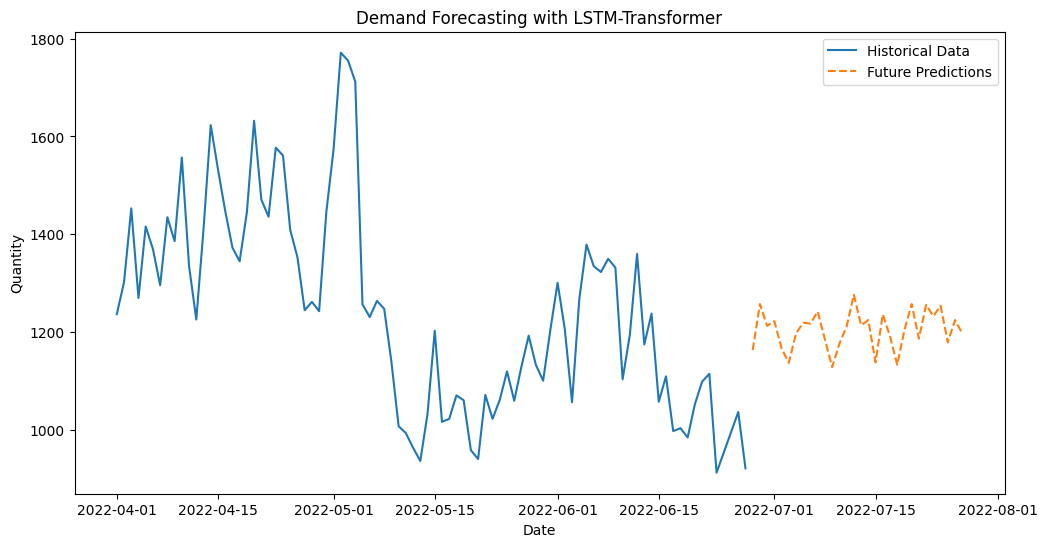

In [20]:
# Forecast future values (rolling prediction)
pred_days = 30
future_preds = []
input_seq = qty_values[-seq_len:].unsqueeze(0).unsqueeze(-1).to(device)

with torch.no_grad():
    for _ in range(pred_days):
        pred = lstm_transformer_model(input_seq)
        future_preds.append(pred.item())
        new_input = torch.cat((input_seq[:, 1:, :], pred.unsqueeze(0)), dim=1)
        input_seq = new_input

# Inverse transform predictions
future_preds = np.array(future_preds).reshape(-1, 1)
future_preds = sc_qty.inverse_transform(future_preds)
window_size = 3
future_preds_smoothed = np.convolve(future_preds.flatten(), np.ones(window_size)/window_size, mode='valid') # Simple Moving Average (SMA)
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], sc_qty.inverse_transform(df['Qty'].values.reshape(-1, 1)), label='Historical Data')
future_dates = pd.date_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=pred_days)
plt.plot(future_dates, future_preds, label='Future Predictions', linestyle='--')
plt.legend()
plt.title('Demand Forecasting with LSTM-Transformer')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()


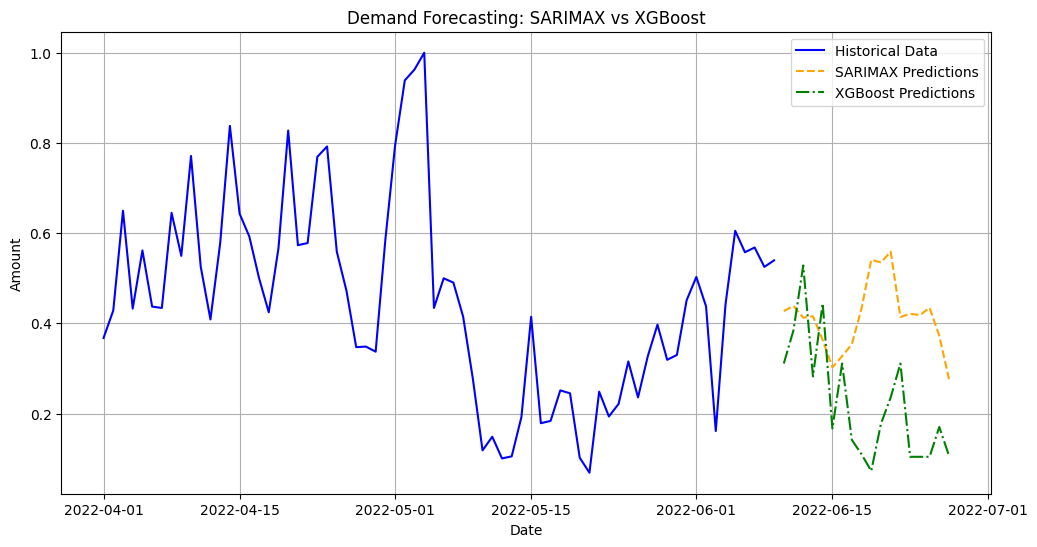

In [21]:
# Assuming 'train' and 'test' dataframes have a 'Date' column
dates = test.index

# Plot
plt.figure(figsize=(12, 6))

# Historical data
plt.plot(train.index, train['Amount'], label='Historical Data', color='blue')

# SARIMAX predictions
plt.plot(dates, sarima_preds, label='SARIMAX Predictions', linestyle='--', color='orange')

# XGBoost predictions
plt.plot(dates, xgb_preds, label='XGBoost Predictions', linestyle='-.', color='green')

# Title and labels
plt.title('Demand Forecasting: SARIMAX vs XGBoost')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()
